In [1]:
%%file exo1.py

# EXO1
from mpi4py import MPI
COMM = MPI.COMM_WORLD 
SIZE = COMM.Get_size() 
RANK = COMM.Get_rank()

if RANK==0:
    print("Hello World. RANK: {RANK} among {SIZE} PROCESS".format(RANK = RANK, SIZE = SIZE))

Overwriting exo1.py


In [3]:
%%file exo2.py

from mpi4py import MPI

COMM = MPI.COMM_WORLD 
SIZE = COMM.Get_size() 
RANK = COMM.Get_rank()

data = 0
while True:
    # Collect Data and broacast
    if RANK == 0:
        data = int(input(""))
        if data < 0:
            COMM.Abort()
        for process in range(SIZE):
            COMM.send(data, dest=process)
    
    # Print received data
    receiveBuff = COMM.recv(source=0)
    # if receiveBuff < 0:
    #     break
    # else:
    print(f"Process {RANK} got {receiveBuff}")

Overwriting exo2.py


In [4]:
%%file exo3.py

from mpi4py import MPI

COMM = MPI.COMM_WORLD 
SIZE = COMM.Get_size() 
RANK = COMM.Get_rank()

if SIZE != 2 and RANK == 0:
    print("This program requires exactly 2 processes.")
    COMM.Abort()

num_process = (RANK+1)%2
shared_variable = 0

for iter in range(10):
    #Ping-Pong
    if RANK == iter % 2:
        COMM.send(shared_variable, dest=num_process)
    else:
        received_data = COMM.recv(source=num_process)
        shared_variable = received_data + 1
        print(f"Process {RANK} got {received_data} from Process {num_process}")

Overwriting exo3.py


In [5]:
%%file exo4.py

from mpi4py import MPI

COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

if RANK == 0:
    # Get input
    data = int(input(""))

    # Send
    COMM.send(data + RANK, dest=1)
    print(f"Process {RANK}: Received data {data}")
else:
    # Receive data
    received_data = COMM.recv(source=RANK - 1)
    print(f"Process {RANK}: Received data {received_data}")

    # Send to next
    if RANK != SIZE - 1:
        COMM.send(received_data + RANK, dest=RANK + 1)

Overwriting exo4.py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Condition initiale
def f(x):
    if (300 <= x <= 400):
        return 10
    return 0

# Dimenssions(Longeur) de la barre
L = 1000

# Nombre de neuds
N = 200

# Pas du maillage
dx = L / (N-1)

# Maillage de la barre
x = np.linspace(0, L, N)

# Conditions limites
U = np.array([f(x[i]) for i in range(N)])

a = 1
temps = 0
tempsArret = 2000
CFL = 1

dt = CFL * (dx/abs(a))
lamba = dt * (a/dx)

Unew = np.zeros(N)

while (temps < tempsArret):
    for i in range(1, N-1):
        # Décentré amont
        #Unew[i] = U[i] - lamba*(U[i] - U[i-1]) 
        
        # Décentré aval
        #Unew[i] = U[i] - lamba*(U[i+1] - U[i])
        
        # Schema centré
        #Unew[i] = U[i] - (lamba/2)*(U[i+1] - U[i-1]) 
        
        # Schema de Lax-Friedrich
        #Unew[i] = (U[i-1] + U[i+1])/2 - (lamba/2)*(U[i+1] - U[i-1]) 
        
        # Schema Lax-Wendroff
        beta = 1
        Unew[i] = U[i] - (lamba/2)*(U[i+1] - U[i-1]) + beta*(lamba**2/2)*(U[i-1] - 2*U[i] + U[i+1])
        
    Unew[0] = Unew[N-1] # Periodique
    Unew[N-1] = Unew[N-2]
    temps += dt
    U = Unew.copy()
    #plt.figure()
    plt.grid()
    plt.plot(x, U, '-r')
    plt.pause(0.01)

In [4]:
%%file exo5-parallel-sp.py


# Import requirements
#from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

# Initialize shared comm utils
#COMM = MPI.COMM_WORLD
#SIZE = COMM.Get_size()
#RANK = COMM.Get_rank()

# Initial condition
def f(x):
    if (300 <= x <= 400):
        return 10
    return 0

# Bar Length & speed
L = 1000
c = 1

# Space mesh
Nx = 200
dx = L / (Nx-1)
x = np.linspace(0, L, Nx)

# Time mesh
CFL = 1
Nt = 2000
dt = CFL * (dx/abs(c))

# Init
u = np.array([f(x[i]) for i in range(Nx)])
un = np.zeros(Nx)
    
# Solver function
def solve_1d_linearconv(u, un, nt, nx, dt, dx, c):
    for n in range(nt):  
        # Iterrative update
        un = u.copy()
        for i in range(1, nx): 
            u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
            
        # Boundaries conditions
        u[0] = u[nx-1]
        u[nx-1] = u[nx-2]
    return 0

# Solve and plot solution
solve_1d_linearconv(u, un, Nt, Nx, dt, dx, c)
plt.figure()
plt.grid()
plt.plot(x, u, '-')

Writing exo5-parallel-sp.py


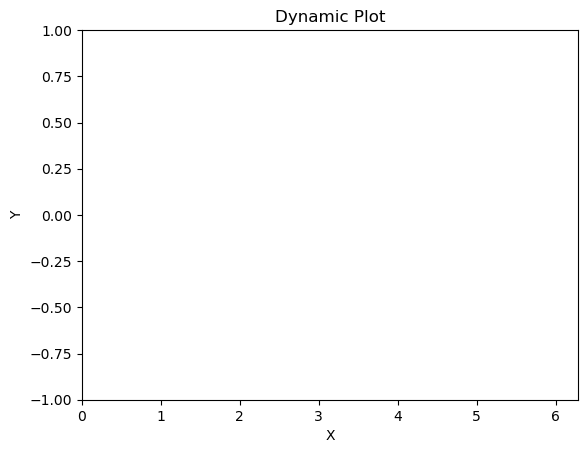

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Initialize figure and axis
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'r-', animated=True)

# Set up the plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Dynamic Plot')

# Initialization function: plot the background of each frame
def init():
    ln.set_data([], [])
    return ln,

# Update function: this is called for each frame of the animation
def update(frame):
    x = np.linspace(0, 2*np.pi, 100)
    y = np.sin(x + frame * 0.1)
    ln.set_data(x, y)
    return ln,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(100),
                    init_func=init, blit=True)

# Show the animation
plt.show()


x (features):
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
y (target):
[0.75778494 1.87152788 1.47316396 0.99856008 0.29007009]


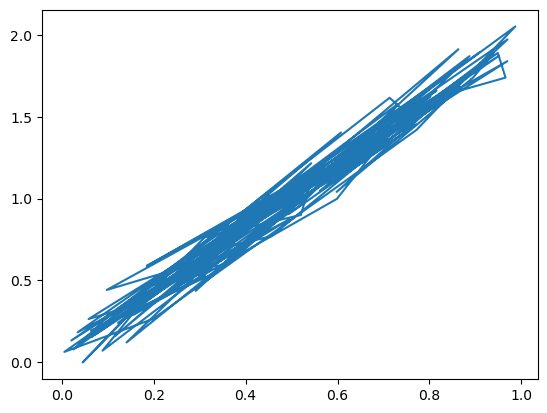

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset
n_samples = 100  # Number of samples
x = np.random.rand(n_samples)  # Generate random feature values between 0 and 1
noise = np.random.randn(n_samples) * 0.1  # Generate Gaussian noise with mean 0 and standard deviation 0.1
y = 2 * x + noise  # Compute target variable with linear relationship y = 2x + noise

# Reshape x to a column vector
# x = x.reshape(-1, 1)

# Print first few samples
print("x (features):")
print(x[:5])
print("y (target):")
print(y[:5])

plt.plot(x, y)

In [4]:
from COLLECTIVE.utils import generate_dataset

In [25]:
dataset = generate_dataset(relation="2*x1 + 3*x2 - 9*x3", n_samples=1000, with_noise=False, random_state=42)

In [26]:
dataset.head()

,x1,x2,x3,y
0,0.374540,0.950714,0.731994,-5.96882051752435
1,0.598658,0.156019,0.155995,0.703796729281587
2,0.058084,0.866176,0.601115,-6.41910445198340
3,0.708073,0.020584,0.969910,3.87877698904990
4,0.832443,0.212339,0.181825,0.949925860710981


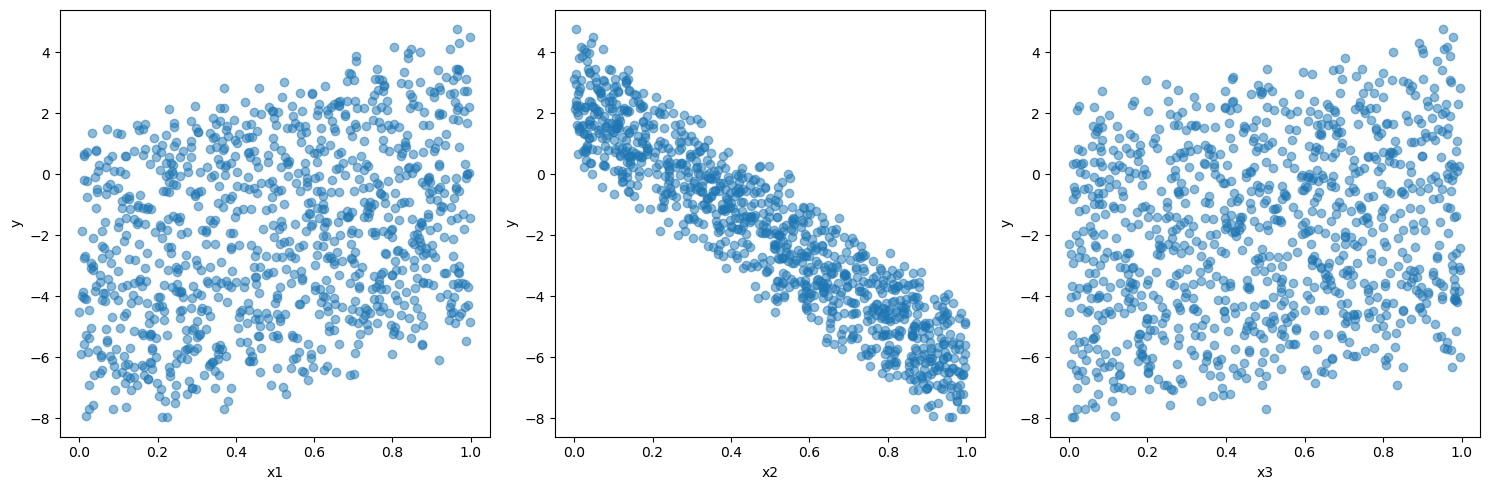

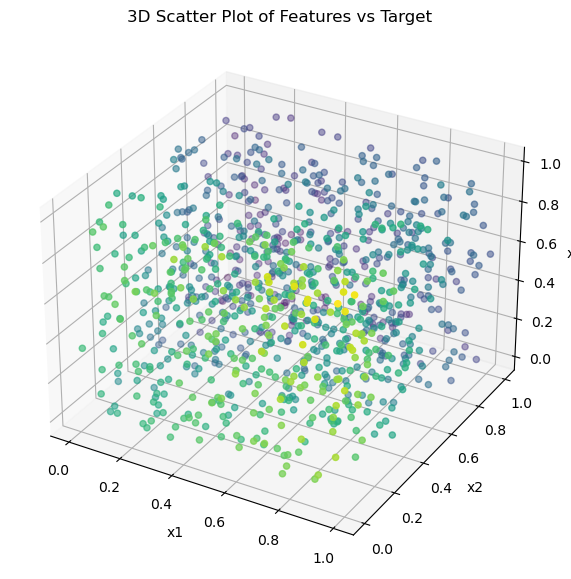

In [27]:
# Scatter plot for each feature vs target variable
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['x1', 'x2', 'x3']):
    axs[i].scatter(dataset[feature], dataset['y'], alpha=0.5)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('y')

plt.tight_layout()
plt.show()

# 3D scatter plot for all features vs target variable
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataset['x1'], dataset['x2'], dataset['x3'], c=dataset['y'], cmap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('3D Scatter Plot of Features vs Target')
plt.show()

In [36]:
dataset.iloc[[1, 2, 3], :]

,x1,x2,x3,y
1,0.598658,0.156019,0.155995,0.703796729281587
2,0.058084,0.866176,0.601115,-6.41910445198340
3,0.708073,0.020584,0.969910,3.87877698904990
